# Assignment 5

#### Imports and Inits

In [1]:
from interpret.glassbox import ExplainableBoostingClassifier      
from interpret.perf import ROC                                    
import numpy as np                                                                           
import pandas as pd                                              
import time                                                       

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

%matplotlib inline

SEED = 12345 
np.random.seed(SEED)

NTHREAD = 4

#### Starting global timer

In [2]:
tic = time.time()

#### Importing Data

In [3]:
data = pd.read_csv('hmda_train_preprocessed.csv')

In [4]:
y = 'high_priced'

### Fitting Interpretable Model

#### Splitting data into train and validation partitions

In [5]:
np.random.seed(SEED) 

split_ratio = 0.7 

split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Explainable Boosting Machine (EBM)

#### Retraining most accurate model above 0.8 AIR to debug

In [6]:
rem_params = {'max_bins': 512,
              'max_interaction_bins': 16,
              'interactions': 10,
              'outer_bags': 4,
              'inner_bags': 0,
              'learning_rate': 0.001,
              'validation_size': 0.25,
              'min_samples_leaf': 5,
              'max_leaves': 5,
              'early_stopping_rounds': 100.0,
              'n_jobs': NTHREAD, 
              'random_state': SEED}

rem_x = ['property_value_std',
               'no_intro_rate_period_std',
               'loan_amount_std',
               'income_std',
               'conforming',
               'intro_rate_period_std',
               'debt_to_income_ratio_std',
               'term_360']

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x], train[y]) 
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x], valid[y])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Remediated EBM retrained with AUC: 0.7863.


### Sensitivity Analysis: Stress Testing

#### Simulating recession conditions in validation data

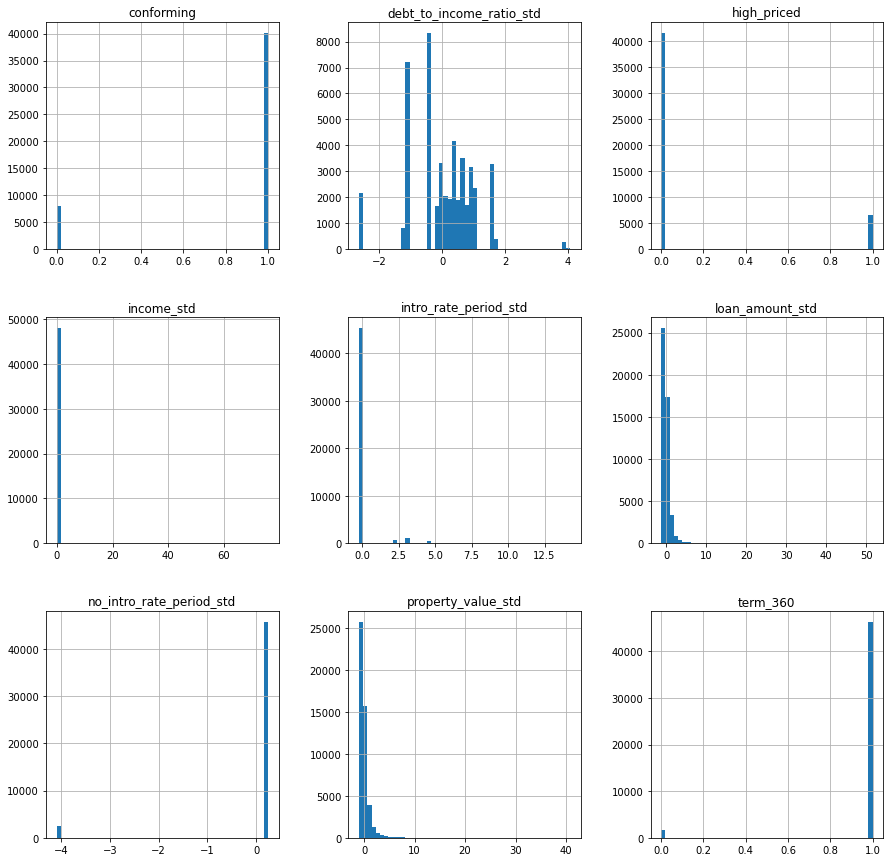

In [7]:
np.random.seed(SEED) # set seed for this cell

rec_valid = valid.copy(deep=True) # deep copy of validation data

# use severity variable to control how many customers are affected
severity = 0.1
affected = np.random.rand(len(rec_valid)) < severity

# decrease property values by 5%
rec_valid.loc[affected, 'property_value_std'] = rec_valid.loc[affected, 'property_value_std'] * 0.95

# less intro rates
rec_valid.loc[affected, 'no_intro_rate_period_std'] = 0.2443944

# lower loan amounts by 5%
rec_valid.loc[affected, 'loan_amount_std'] = rec_valid.loc[affected, 'loan_amount_std'] * 0.95

# lower income by 5%
rec_valid.loc[affected, 'income_std'] = rec_valid.loc[affected, 'income_std'] * 0.95

# less conforming loans
rec_valid.loc[affected, 'conforming'] = 0

# shorter intro rate periods
rec_valid.loc[affected, 'loan_amount_std'] = rec_valid.loc[affected, 'loan_amount_std'] * 0.95

# 5% higher debt-to-income ratios 
rec_valid.loc[affected, 'debt_to_income_ratio_std'] = rec_valid.loc[affected, 'debt_to_income_ratio_std'] * 1.05

# more long loans
rec_valid.loc[affected, 'term_360'] = 1

# update target
rec_valid.loc[affected, y] = np.random.choice(2, len(rec_valid.loc[affected, y]))

# visualize results
_ = rec_valid[rem_x + [y]].hist(bins=50, figsize=(15, 15))

#### Finding AUC for best model in simulated recession conditions

In [8]:
rec_rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(rec_valid[rem_x], rec_valid[y])
rec_rem_auc = rec_rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rec_rem_auc)

Remediated EBM retrained with AUC: 0.6579.


### Residual Analysis

#### Calculating predictions and logloss residuals for all data

In [9]:
yhat = 'phat'
r_name = 'r' 

rem_ebm_phat = pd.DataFrame(rem_ebm.predict_proba(data[rem_x])[:, 1], columns=['phat']) 
rem_ebm_phat = pd.concat([data.reset_index(drop=True), rem_ebm_phat], axis=1)

rem_ebm_phat[r_name] = -rem_ebm_phat[y]*np.log(rem_ebm_phat[yhat]) -\
                       (1 - rem_ebm_phat[y])*np.log(1 - rem_ebm_phat[yhat])   

#### Plotting residuals

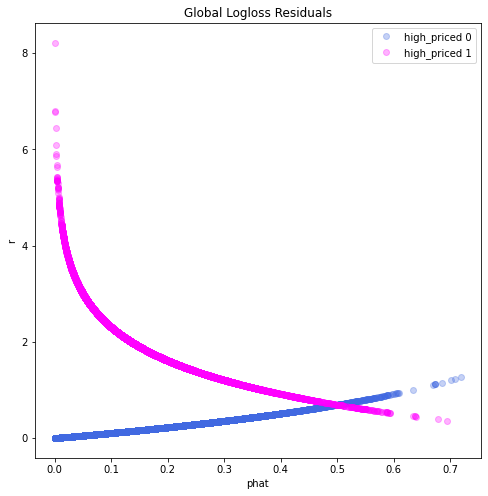

In [10]:
fig, ax_ = plt.subplots(figsize=(8, 8))         

color_list = ['royalblue', 'magenta'] 
c_idx = 0
groups = rem_ebm_phat.groupby(y) 
for name, group in groups:
    ax_.plot(group.phat, group.r, 
             label=' '.join([y, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1

_ = plt.xlabel(yhat)
_ = plt.ylabel(r_name)
_ = ax_.legend(loc=1)
_ = plt.title('Global Logloss Residuals')

### Remediation: Removing Outliers

#### Finding outliers

In [11]:
rem_ebm_phat.sort_values(by='r', ascending=False).head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat,r
82041,82041,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,-0.954117,-2.973067,0.244394,-0.215304,0.697459,-0.052781,-0.425131,1,0.000270,8.216428
110822,110822,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.892723,-0.874794,0.244394,-0.215304,1.252485,-0.007738,-1.156406,1,0.001118,6.795930
83113,83113,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.760806,-0.277030,0.244394,-0.215304,0.697459,0.017208,-0.059493,1,0.001149,6.769069
128930,128930,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.130006,-3.257582,0.244394,-0.215304,0.759128,0.008893,0.854601,1,0.001608,6.433062
2650,2650,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.948060,-0.442940,0.244394,-0.215304,1.900015,-0.052781,-2.527547,1,0.002263,6.091081


#### Removing worst outliers

In [12]:
n_remove = 10
rem_data = data.copy(deep=True)
rem_data.drop(list(rem_ebm_phat.sort_values(by='r', ascending=False).head(n=n_remove).index), axis=0, inplace=True)

### Remediation: Down-sample to increase signal from high-priced loans

In [13]:
inverse_proportion_remove = 2 
rem_data.drop(list(rem_data[rem_data[y] == 0].index)[::inverse_proportion_remove], axis=0, inplace=True)

#### Retraining remediated EBM

In [14]:
np.random.seed(SEED)

split = np.random.rand(len(rem_data)) < split_ratio
rem_train = rem_data[split]
rem_valid = rem_data[~split]

print('Remediated train data rows = %d, columns = %d' % (rem_train.shape[0], rem_train.shape[1]))
print('Remediated validation data rows = %d, columns = %d' % (rem_valid.shape[0], rem_valid.shape[1]))

rem_ebm2 = ExplainableBoostingClassifier(**rem_params)
rem_ebm2.fit(rem_train[rem_x], rem_train[y]) 
rem_ebm_perf2 = ROC(rem_ebm2.predict_proba).explain_perf(rem_valid[rem_x], rem_valid[y])
rem_auc2 = rem_ebm_perf2._internal_obj['overall']['auc']
print('Remediated EBM under-sampled AUC: %.4f.' % rem_auc2)

Remediated train data rows = 61518, columns = 23
Remediated validation data rows = 26393, columns = 23
Remediated EBM under-sampled AUC: 0.7917.


#### Testing remediated EBM on true validation data

In [15]:
rem_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x])[:, 1], columns=['phat']) 
rem_ebm_phat2 = pd.concat([valid.reset_index(drop=True), rem_ebm_phat2], axis=1)
rem_ebm_perf3 = ROC(rem_ebm2.predict_proba).explain_perf(valid[rem_x], valid[y])
rem_auc3 = rem_ebm_perf3._internal_obj['overall']['auc']
print('Remediated EBM true AUC: %.4f.' % rem_auc3) 

Remediated EBM true AUC: 0.7953.


#### Ending global timer

In [16]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 733.58 s.
